# Introduction

This notebook is a demo of how to create a photo collage of any shape. You need to provide a silhouette of the shape you want. The silhouett will be loaded as a grey-scale image ranging from 0 to 255. We then seperate the object from the backgrouond using thresholding. The object pixels are set to 0 and the background pixel are set to 1. The background threshold is tunable. The silhouette will be reshaped to the same size as the output collage.

We devide the collage into grids where each cell in the grid is a square with specified cell width. Note that the cell width must be diviable by the collage width and height. The photos are first placed in the grid roughly representing the provides shape (like an extremely pixelated image) and are then masked using the thresholded silhouette so the collage has the exact shape. A cell will contain an image if it contains at least 5% of the shape. The threshold is tunable. We will create 2 batches of photos for the shape: one batch will be placed at the boarder of the shape, which will most likely be cropped by the mask; the other batch will be placed inside the shape. The boarder is defined by the percentage of the shape in a given grid. The threshold is tunable and is default to 75%. There is a 15 pixels boarder between each cell, also tunable.

The photos to fill the collage must either be a .jpg or .png file. The photos will be reshaped to a sqaure by cropped on one axis and will be resized to the cell size. Before createing the collage, we first traverse silhouette to find out how many images we need to fill the collage (both inside and at the boarder). If we need more image than we have, some images will be randomly duplicated. Ideally, you will want to have slightly less images than requires, so you can use all your photos while not creating too many duplicates. Note that we assume the photos and the collage uses RGB to represent colours.

To see a full list of inputs and tunable paramters, check out the `Set-ups.Parameters` section below.

# Set-ups

## Packages

In [ ]:
!conda install -c conda-forge opencv
!conda install numpy
!conda install matplotlib

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

## Parameters

In [2]:
# Inputs:
image_folder = '/Users/liushuhao/Desktop/photography/Collage Maker/Demo/images'  # path to the folder of images
silhouette_file = './plane_silhouette.jpg'  # path to the reference silhouette image
output_file = './output_collage.jpg'  # output file name

# Parameters:
background_threshold = 200  # background threshold of the silhouette
width, height = 6000, 4000  # collage width and height

cell_width = 200  # width of the cells in the collage grid
padding = 15  # padding pixels between cells

shape_threshold = 0.05  # minimum percentage of shape in a cell to place a partial photo
boarder_threshold = 0.75  # minimum percentage of shape in a cell to be considered as a inside cells

# Load Images

## Load Silhouette Image

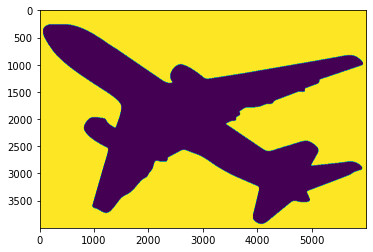

In [3]:
silhouette = cv2.imread(silhouette_file, 0)  # Load as grayscale
# Seperate shape from background
silhouette = cv2.GaussianBlur(silhouette, (9,9), 5)
silhouette[silhouette < background_threshold] = 0
silhouette[silhouette >= background_threshold] = 1

# Resize silhouette to desired collage size
collage_size = (width, height)
silhouette = cv2.resize(silhouette, collage_size)
plt.imshow(silhouette)

## Load Collage Photos

In [4]:
images = []
for filename in os.listdir(image_folder):
    if filename[-4:].lower() in (".jpg", ".png"):
        # load RBG image
        img = cv2.imread(os.path.join(image_folder, filename))
        assert len(img.shape) == 3, "Collage images must be RBG images."
        # crop the image to a square
        h, w, d = img.shape
        l = min(h, w)
        img = img[int((h-l)/2):int((h-l)/2)+l, int((w-l)/2):int((w-l)/2)+l, ]
        images.append(img)
np.random.shuffle(images)
print(f"Loaded {len(images)} images from the image folder.")

Loaded 473 images from the image folder.


# Create Collage

## Determine how many images are needed

In [5]:
count_full = 0
count_partial = 0
for r in range(0, height, cell_width):
    for c in range(0, width, cell_width):
        # if part (black) is more than 50%, place a full image
        if np.sum(silhouette[r:r+cell_width, c:c+cell_width] == 0) / (cell_width*cell_width) >= boarder_threshold:
            count_full += 1
        # if part (black) is more than 5%, place a partial image
        elif np.sum(silhouette[r:r+cell_width, c:c+cell_width] == 0) / (cell_width*cell_width) >= shape_threshold:
            count_partial += 1
print(f"Need {count_full} full images and {count_partial} partial images.")

Need 187 full images and 77 partial images.


## Assign full images and partial images

In [6]:
partial_images = images.copy()
full_images = images

if count_full > len(full_images):
    full_images.extend(np.random.choice(full_images, count_full-len(full_images), replace=True))
else:
    full_images = full_images[:count_full]

if count_partial > len(partial_images):
    partial_images.extend(np.random.choice(partial_images, count_partial-len(partial_images), replace=True))
else: 
    # Prioritize the images not used in full_images
    partial_images = partial_images[-count_partial:]
    
print(f"Have {len(full_images)} full images and {len(partial_images)} partial images.")

Have 187 full images and 77 partial images.


## Assemble collage

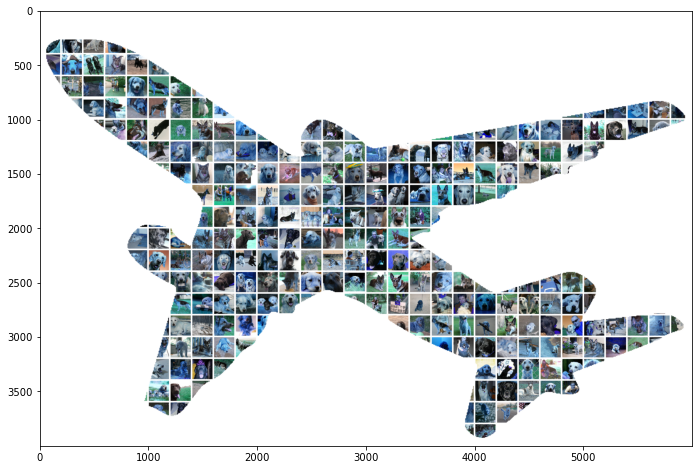

In [7]:
# Fill in cells
collage = np.full((height, width, 3), 255, dtype=np.uint8)
img_size = cell_width - padding
for r in range(0, height, cell_width):
    for c in range(0, width, cell_width):
        # if part (black) is more than 50%, place a full image
        if np.sum(silhouette[r:r+cell_width, c:c+cell_width] == 0) / (cell_width*cell_width) >= boarder_threshold:
            img = full_images.pop()
            for i, color_spectrum in enumerate("rgb"):
                collage[r:r+img_size, c:c+img_size, i] = cv2.resize(img[:,:,i], (img_size,img_size))
        # if part (black) is more than 5%, place a partial image
        elif np.sum(silhouette[r:r+cell_width, c:c+cell_width] == 0) / (cell_width*cell_width) >= shape_threshold:
            img = partial_images.pop()
            for i, color_spectrum in enumerate("rgb"):
                collage[r:r+img_size, c:c+img_size, i] = cv2.resize(img[:,:,i], (img_size,img_size))
# Apply shape masking
collage[silhouette == 1] = 255
plt.figure(figsize = (12,8))
plt.imshow(collage)

## Save to File

In [8]:
cv2.imwrite(output_file, collage)

True